# Exploring Store Sales Data and Using Time Series Forecasting

### Data can be found from here https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [77]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os


import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline

import warnings

warnings.filterwarnings("ignore")


plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

### Loading Data

In [78]:
DATA_PATH = os.path.join(os.getcwd(), "data")
stores = pd.read_csv(os.path.join(DATA_PATH, "stores.csv"))
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), parse_dates=["date"])
test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"), parse_dates=["date"])
oil = pd.read_csv(os.path.join(DATA_PATH, "oil.csv"), parse_dates=["date"]).rename(
    columns={"dcoilwtico": "oil_price"}
)
transactions = pd.read_csv(
    os.path.join(DATA_PATH, "transactions.csv"), parse_dates=["date"]
)
holidays = pd.read_csv(
    os.path.join(DATA_PATH, "holidays_events.csv"), parse_dates=["date"]
)

In [79]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [80]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [81]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [82]:
oil

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [83]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


### We need to clean the dataframes up. First lets check some basic information about the dates from the train and test sets. Since we will be doing time series analysis this is very important.

In [84]:
num_families = train.family.nunique()
print(f"Number of different family types: {num_families}")
num_stores = train.store_nbr.nunique()
print(f"Number of different stores: {num_stores}")
num_target_series = train.groupby(["store_nbr", "family"]).ngroups
print(f"Number of target series: {num_target_series}")
train_start_date = train.date.min().date()
train_end_date = train.date.max().date()
num_train_days = train.date.nunique()
print(
    f"Training date range: {num_train_days} days from {train_start_date} to {train_end_date}"
)
train_date_range = (train_end_date - train_start_date).days + 1
test_start_date = test.date.min().date()
test_end_date = test.date.max().date()
num_test_days = test.date.nunique()
print(
    f"Test date range: {num_test_days} days from {test_start_date} to {test_end_date}"
)
test_date_range = (test_end_date - train_start_date).days + 1

Number of different family types: 33
Number of different stores: 54
Number of target series: 1782
Training date range: 1684 days from 2013-01-01 to 2017-08-15
Test date range: 16 days from 2017-08-16 to 2017-08-31


In [85]:
missing_dates = pd.date_range(train_start_date, train_end_date).difference(
    train.date.unique()
)
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()
print(f"Missing dates: {missing_dates}")

Missing dates: ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


Clearly the store is closed on Christmas. So for these dates every year we want to fill in the missing dates with the sales and onpromotion column values set to 0 since there were no sales/promotions on Christmas. Additionally, we can use a multiindex of dates, store number, and the family to organize our data nicely.

In [86]:
idx = pd.MultiIndex.from_product(
    [
        pd.date_range(train_start_date, train_end_date),
        train.store_nbr.unique(),
        train.family.unique(),
    ],
    names=["date", "store_nbr", "family"],
)


train = train.set_index(["date", "store_nbr", "family"]).reindex(idx).reset_index()

train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.0)
train.id = train.id.interpolate(method="linear")

In [87]:
train

,date,store_nbr,family,id,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0
4,2013-01-01,1,BOOKS,4.0,0.000,0.0
...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0


We can see that the reindexing worked as expected and the date, store number, and family type are all now a multi index. Now we should look through the oil data.

In [88]:
missing_oil_dates = pd.date_range(
    train_start_date, test_end_date).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_weekend_days_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_weekend_days = (
    pd.date_range(train_start_date, test_end_date).weekday >= 5
).sum()

print(
    f"""
Number of dates with missing oil data: {num_missing_oil_dates}
Number of weekend days with missing oil data: {num_weekend_days_missing}
Total number of weekend days: {total_num_weekend_days}
"""
)


Number of dates with missing oil data: 486
Number of weekend days with missing oil data: 486
Total number of weekend days: 486



We need a method to fill in these missing values, for now we can use the simplest method which is interpolation.

In [89]:
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start_date, test_end_date)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil_price = oil.oil_price.interpolate(
    method="linear", limit_direction="both")

train = train.merge(oil, on=["date"], how="left")
num_missing = train["oil_price"].isnull().sum()
print(f"Number of dates with missing oil data: {num_missing}")

Number of dates with missing oil data: 0


Next we should investigate the transactions data.

In [90]:
# Find the stores where for a given day there were zero sales in a given family.
num_no_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_num_records = abs(num_stores * train_date_range)
current_num_records = len(transactions.index)
missing_num_records = total_num_records - current_num_records - num_no_sales

print(
    f"""
The correct number of records : {total_num_records}
Current number of records : {current_num_records}
Number of entries with zero sales : {num_no_sales}
Number of missing transactions records : {missing_num_records}
"""
)


The correct number of records : 91152
Current number of records : 83488
Number of entries with zero sales : 7546
Number of missing transactions records : 118



In [91]:
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

transactions = transactions.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

transactions.loc[transactions.sales.eq(0), "transactions"] = 0.0
transactions = transactions.drop(columns=["sales"])

transactions.transactions = transactions.groupby(
    "store_nbr", group_keys=False
).transactions.apply(
    lambda row: row.interpolate(method="linear", limit_direction="both")
)
train = train.merge(transactions, on=["date", "store_nbr"], how="left")

train

,date,store_nbr,family,id,sales,onpromotion,oil_price,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0,93.14,0.0
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0,93.14,0.0
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0,93.14,0.0
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0,93.14,0.0
4,2013-01-01,1,BOOKS,4.0,0.000,0.0,93.14,0.0
...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0,47.57,2155.0
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0,47.57,2155.0
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0,47.57,2155.0
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0,47.57,2155.0


In [92]:
train = train.merge(stores, on=["store_nbr"], how="left")
train

,date,store_nbr,family,id,sales,onpromotion,oil_price,transactions,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,4.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0,47.57,2155.0,Quito,Pichincha,B,6
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0,47.57,2155.0,Quito,Pichincha,B,6
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0,47.57,2155.0,Quito,Pichincha,B,6
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0,47.57,2155.0,Quito,Pichincha,B,6


### Now lets investigate some of the relationships between the data given to us

In [93]:
sales_target_series = pd.pivot_table(
    train, values="sales", index="date", columns=["store_nbr", "family"]
)
transactions_target_series = pd.pivot_table(
    train, values="transactions", index="date", columns=["store_nbr", "family"]
)
promotion_target_series = pd.pivot_table(
    train, values="onpromotion", index="date", columns=["store_nbr", "family"]
)

sales_target_series.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

In [94]:
# scale target series
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
sales_ts_scaled = sales_target_series.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(
    sales_ts_scaled)

Text(0.5, 1.0, 'Sales by Store Number')

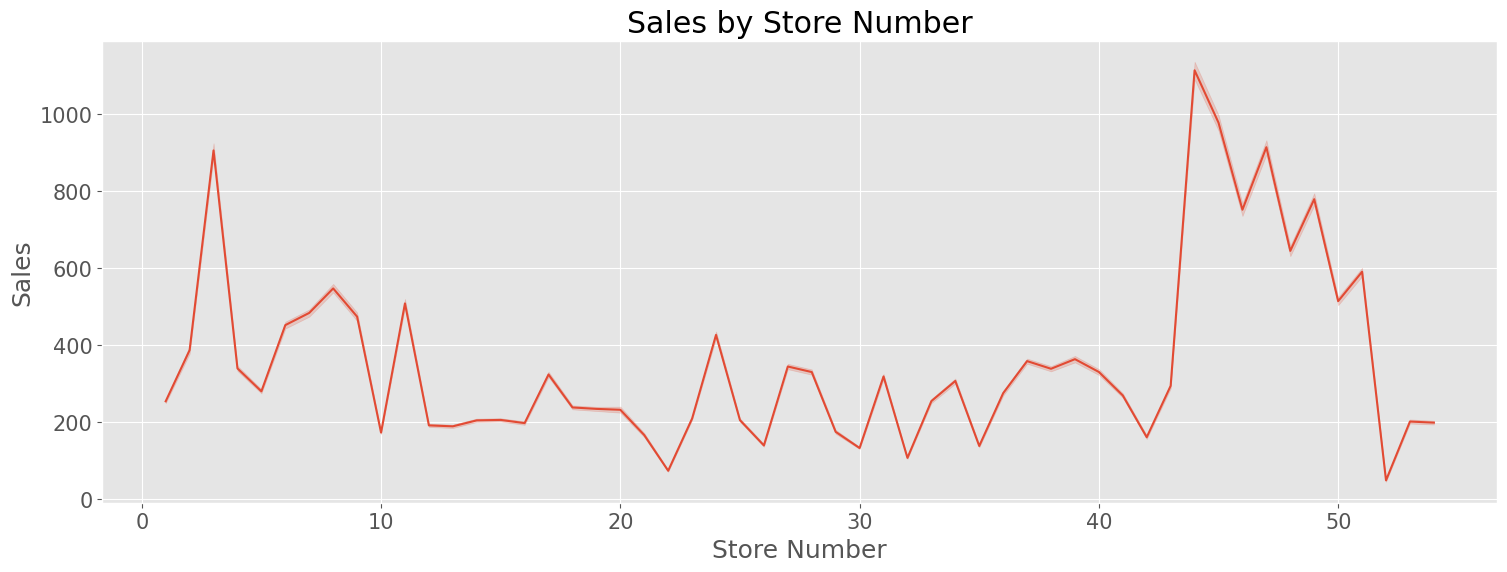

In [95]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=train, x="store_nbr", y="sales")
plt.xlabel("Store Number")
plt.ylabel("Sales")
plt.title("Sales by Store Number")

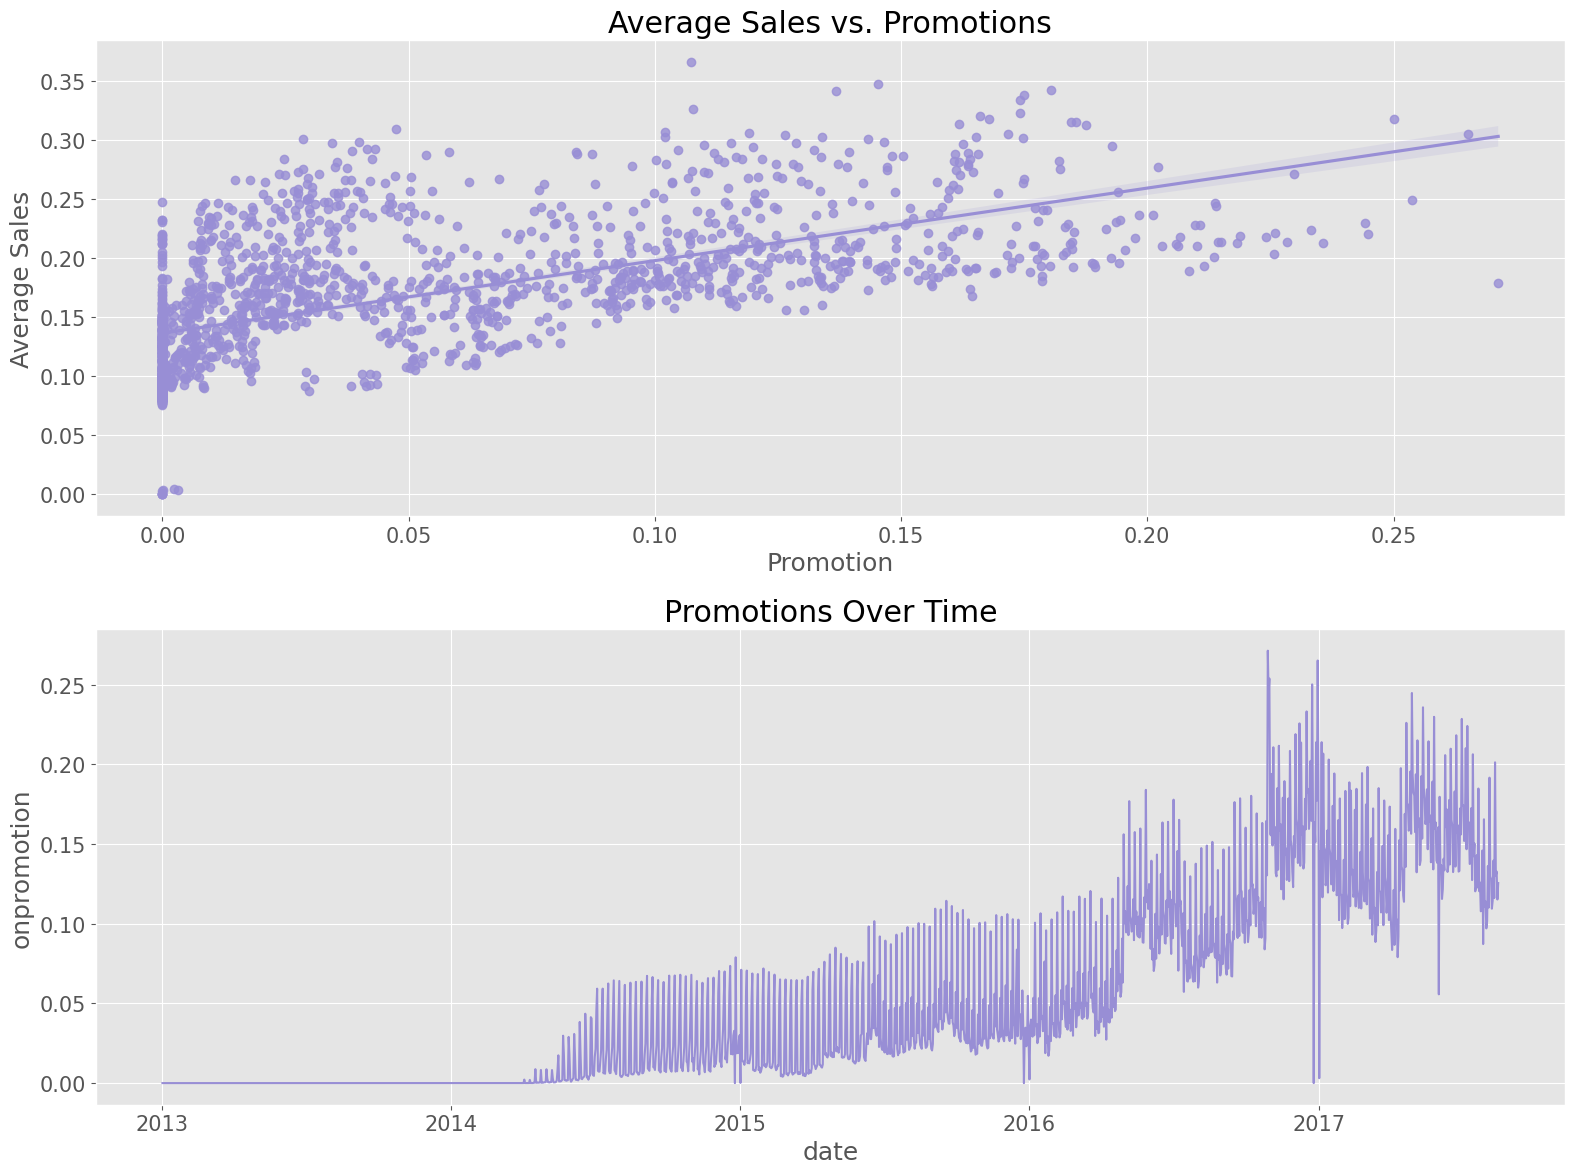

In [96]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 1)

sns.regplot(
    x=mean_promo_ts_scaled.onpromotion,
    y=mean_sales_ts_scaled.sales,
    ax=fig.add_subplot(gs[0, 0]),
    color=COLORS[2],
)
plt.ylabel("Average Sales")
plt.xlabel("Promotion")
plt.title("Average Sales vs. Promotions")

sns.lineplot(
    data=mean_promo_ts_scaled,
    x="date",
    y="onpromotion",
    ax=fig.add_subplot(gs[1, 0]),
    color=COLORS[2],
)
plt.title("Promotions Over Time")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Oil Prices Over Time')

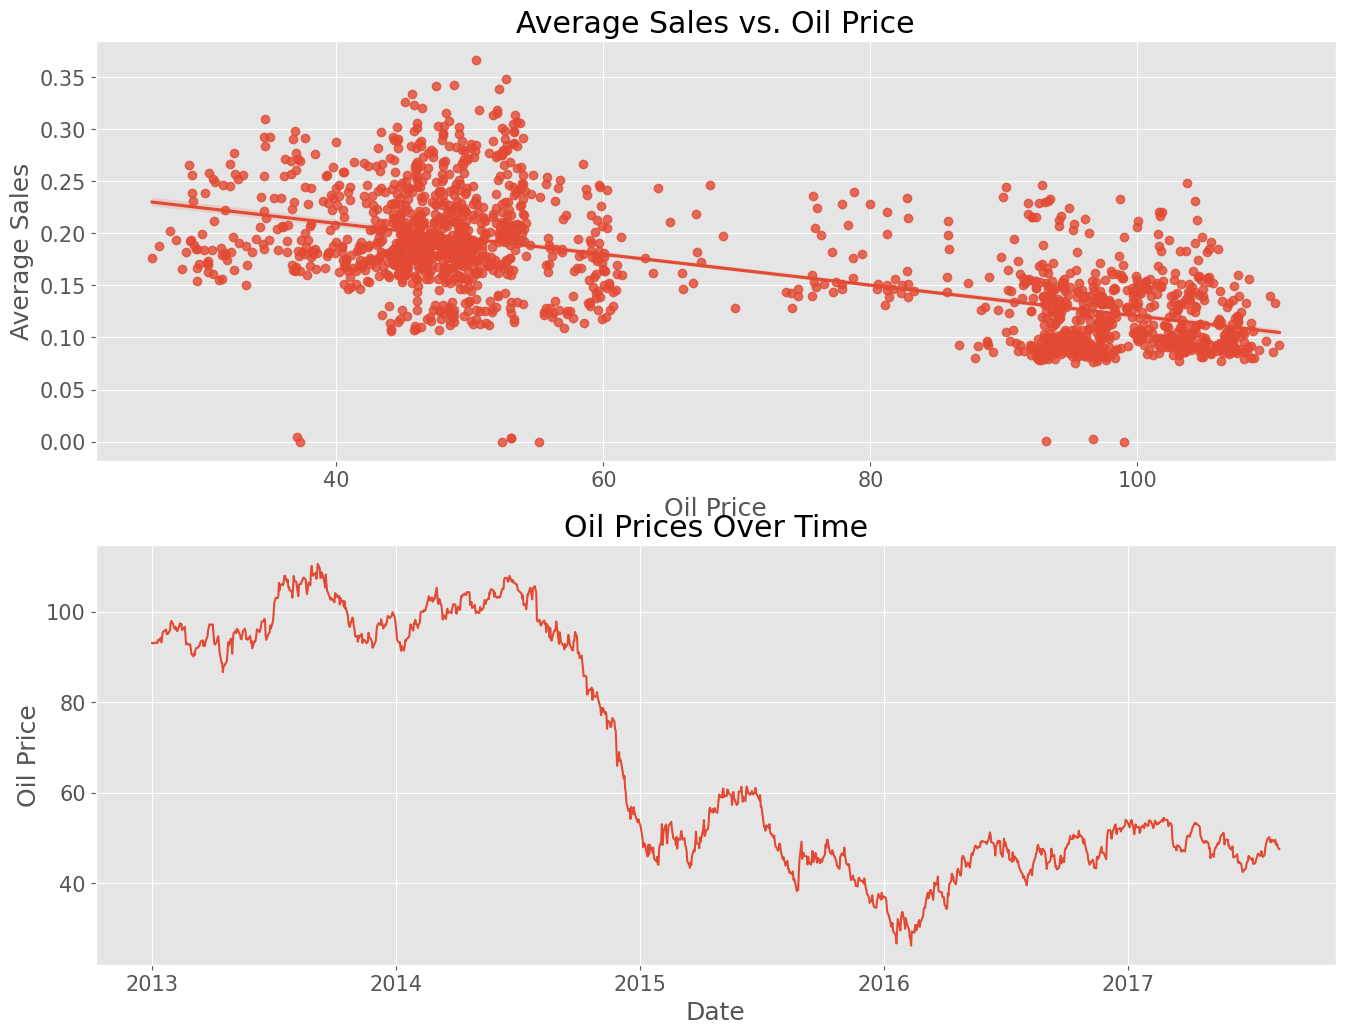

In [100]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 1)

sns.regplot(
    x=oil.oil_price.iloc[:train_date_range],
    y=mean_sales_ts_scaled.sales,
    ax=fig.add_subplot(gs[0, 0]),
    color=COLORS[0],
)
plt.xlabel("Oil Price")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Oil Price")


sns.lineplot(
    data=oil.iloc[:train_date_range, :],
    x="date",
    y="oil_price",
    ax=fig.add_subplot(gs[1, 0]),
    color=COLORS[0],
)
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.title("Oil Prices Over Time")

As we can see there is clearly a negative relationship between oil prices and average sales. Higher oil prices lead to lower sales probably due to inflationary effects.

### We will be conducting time series forecasting so we need to merge the sequential dataset on the date

In [ ]:
train_merged = pd.merge(train, transactions, on=["date", "store_nbr"], how="left")

In [ ]:
train_merged = pd.merge(train_merged, oil, on=["date"], how="left")

In [ ]:
train_merged.rename(columns={"dcoilwtico": "oilprices"}, inplace=True)

### We can merge the store data into the dataset using the store number

In [ ]:
train_merged = pd.merge(train_merged, stores, on=["store_nbr"], how="left")

In [ ]:
train_merged.describe()

,date,store_nbr,id,sales,onpromotion,oil_price_x,transactions_x,cluster_x,transactions_y,oil_price_y,cluster_y
count,3008016,3.008016e+06,3.008016e+06,3.008016e+06,3.008016e+06,3.008016e+06,3.008016e+06,3.008016e+06,3.008016e+06,2.072466e+06,3.008016e+06
mean,2015-04-24 12:00:00.000000512,2.750000e+01,1.500706e+06,3.569279e+02,2.596603e+00,6.787694e+01,1.553912e+03,8.481481e+00,1.553912e+03,6.792559e+01,8.481481e+00
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.619000e+01,1.000000e+00
25%,2014-02-26 18:00:00,1.400000e+01,7.502218e+05,0.000000e+00,0.000000e+00,4.637000e+01,9.270000e+02,4.000000e+00,9.270000e+02,4.638000e+01,4.000000e+00
50%,2015-04-24 12:00:00,2.750000e+01,1.500444e+06,1.100000e+01,0.000000e+00,5.330330e+01,1.330000e+03,8.500000e+00,1.330000e+03,5.333000e+01,8.500000e+00
75%,2016-06-19 06:00:00,4.100000e+01,2.250665e+06,1.950000e+02,0.000000e+00,9.579115e+01,1.975000e+03,1.300000e+01,1.975000e+03,9.580000e+01,1.300000e+01
max,2017-08-15 00:00:00,5.400000e+01,3.000887e+06,1.247170e+05,7.410000e+02,1.106200e+02,8.359000e+03,1.700000e+01,8.359000e+03,1.106200e+02,1.700000e+01
std,NaN,1.558579e+01,8.659927e+05,1.100829e+03,1.220505e+01,2.568157e+01,1.034145e+03,4.649735e+00,1.034145e+03,2.566633e+01,4.649735e+00


In [ ]:
train_merged

,date,store_nbr,family,id,sales,onpromotion,oil_price_x,transactions_x,city_x,state_x,type_x,cluster_x,transactions_y,oil_price_y,city_y,state_y,type_y,cluster_y
0,2013-01-01,1,AUTOMOTIVE,0.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13,0.0,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,1.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13,0.0,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,2.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13,0.0,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,3.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13,0.0,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,4.0,0.000,0.0,93.14,0.0,Quito,Pichincha,D,13,0.0,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3000883.0,438.133,0.0,47.57,2155.0,Quito,Pichincha,B,6,2155.0,47.57,Quito,Pichincha,B,6
3008012,2017-08-15,9,PREPARED FOODS,3000884.0,154.553,1.0,47.57,2155.0,Quito,Pichincha,B,6,2155.0,47.57,Quito,Pichincha,B,6
3008013,2017-08-15,9,PRODUCE,3000885.0,2419.729,148.0,47.57,2155.0,Quito,Pichincha,B,6,2155.0,47.57,Quito,Pichincha,B,6
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3000886.0,121.000,8.0,47.57,2155.0,Quito,Pichincha,B,6,2155.0,47.57,Quito,Pichincha,B,6


### Now we can take the date column and transform it into usable features for the models.

In [ ]:
train_merged["date"] = pd.to_datetime(train_merged["date"])
# train_merged["day"] = train_merged["date"].dt.day
train_merged["month"] = train_merged["date"].dt.month
train_merged["day"] = train_merged["date"].dt.dayofweek
train_merged["is_weekend"] = train_merged["day"] >= 5


train_merged.head()

,date,store_nbr,family,id,sales,onpromotion,oil_price_x,transactions_x,city_x,state_x,...,cluster_x,transactions_y,oil_price_y,city_y,state_y,type_y,cluster_y,month,day,is_weekend
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,93.14,0.0,Quito,Pichincha,...,13,0.0,NaN,Quito,Pichincha,D,13,1,1,False
1,2013-01-01,1,BABY CARE,1.0,0.0,0.0,93.14,0.0,Quito,Pichincha,...,13,0.0,NaN,Quito,Pichincha,D,13,1,1,False
2,2013-01-01,1,BEAUTY,2.0,0.0,0.0,93.14,0.0,Quito,Pichincha,...,13,0.0,NaN,Quito,Pichincha,D,13,1,1,False
3,2013-01-01,1,BEVERAGES,3.0,0.0,0.0,93.14,0.0,Quito,Pichincha,...,13,0.0,NaN,Quito,Pichincha,D,13,1,1,False
4,2013-01-01,1,BOOKS,4.0,0.0,0.0,93.14,0.0,Quito,Pichincha,...,13,0.0,NaN,Quito,Pichincha,D,13,1,1,False


In [ ]:
train_merged.isna()

,date,store_nbr,family,id,sales,onpromotion,oil_price_x,transactions_x,city_x,state_x,...,cluster_x,transactions_y,oil_price_y,city_y,state_y,type_y,cluster_y,month,day,is_weekend
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3008012,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3008013,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3008014,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### There is a lot of missing data in the oilprices column as you can see below

In [ ]:
train_merged.isnull().sum()

date                   0
store_nbr              0
family                 0
id                     0
sales                  0
onpromotion            0
oil_price_x            0
transactions_x         0
city_x                 0
state_x                0
type_x                 0
cluster_x              0
transactions_y         0
oil_price_y       935550
city_y                 0
state_y                0
type_y                 0
cluster_y              0
month                  0
day                    0
is_weekend             0
dtype: int64

Below we can see there is no oil prices data on the weekend. There are probably other dates with missing oil price data as well but we can solve these issues with interpolation.

In [ ]:
train_merged[train_merged["is_weekend"] == True].oilprices

AttributeError: 'DataFrame' object has no attribute 'oilprices'

### We can use interpolation to approximate the oil prices

In [ ]:
train_merged.oilprices = train_merged.oilprices.interpolate(
    method="linear", limit_direction="both"
)

In [ ]:
train_merged["oilprices"].isnull().sum()

0

### Now we can also see that transactions have missing data as well.

We should fill in the missing transactions data with 0 if there were no sales on that day.

In [ ]:
# Need to reindex by date and store number

train_merged.loc[train_merged.sales.eq(0), "transactions"] = 0.0

train_merged.transactions = train_merged.groupby(
    "store_nbr", group_keys=False
).transactions.apply(lambda x: x.interpolate(method="linear", limit_direction="both"))

### Now we should use the holiday data to engineer some features checking if it is a holiday or not.

In [ ]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [ ]:
holidays[holidays["transferred"] == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [ ]:
holidays["date"] = pd.to_datetime(holidays["date"])
holidays = holidays.rename(
    columns={
        "type": "holiday_type",
        "locale": "holiday_locale",
        "locale_name": "holiday_locale_name",
    }
)
holidays = holidays.drop(columns=["description"])

In [ ]:
train_merged = pd.merge(train_merged, holidays, on=["date"], how="left")

In [ ]:
train_merged

,id,date,store_nbr,family,sales,onpromotion,transactions,oilprices,city,state,type,cluster,month,day,is_weekend,holiday_type,holiday_locale,holiday_locale_name,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0,93.14,Quito,Pichincha,D,13,1,1,False,Holiday,National,Ecuador,False
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0,93.14,Quito,Pichincha,D,13,1,1,False,Holiday,National,Ecuador,False
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0,93.14,Quito,Pichincha,D,13,1,1,False,Holiday,National,Ecuador,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0,93.14,Quito,Pichincha,D,13,1,1,False,Holiday,National,Ecuador,False
4,4,2013-01-01,1,BOOKS,0.000,0,0.0,93.14,Quito,Pichincha,D,13,1,1,False,Holiday,National,Ecuador,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,47.57,Quito,Pichincha,B,6,8,1,False,Holiday,Local,Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,47.57,Quito,Pichincha,B,6,8,1,False,Holiday,Local,Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,47.57,Quito,Pichincha,B,6,8,1,False,Holiday,Local,Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,47.57,Quito,Pichincha,B,6,8,1,False,Holiday,Local,Riobamba,False


### Incorporating additional notes into the dataset. 
Wages in the public sector are paid every two weeks on the 15th and on the last day of the month, respectively. We should investigate this and see if sales tend to be higher just after these days.

Additionally, a magnitude 7.8 earthquake struck Ecuador on April 16, 2016. That should be taken into account in some fashion.

### Now we should explore some of the relationships in the dataset

NameError: name 'plt' is not defined

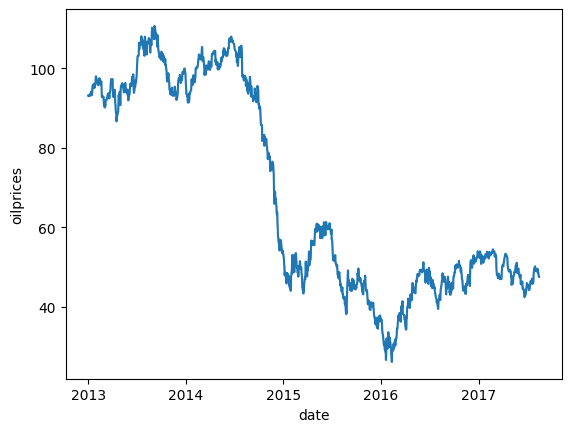

In [ ]:
sns.lineplot(x=train_merged.date, y=train_merged.oilprices)
plt.ylabel("Oil Prices")
plt.title("Oil Prices Over Time")
plt.show()

## Now that the features have been engineered and the data columns have been cleaned we can start to create pipelines for the forecasting models

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor


categorical_cols = ["family", "state", "type"]
# Define preprocessing steps
categorical_transformer = Pipeline(
    steps=[
        # Impute missing values if any
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehotencoder", OneHotEncoder(handle_unknown="ignore")),  # Use OneHotEncoder
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_cols)]
)

In [ ]:
import numpy as np

# Create pipeline
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # Default regressor (will be replaced by grid search)
        ("regressor", LGBMRegressor()),
    ]
)

learning_rate = [0.001, 0.01, 0.1, 0.5, 0.9]
# n_estimators = np.arange(0, 200, 25)
# num_leaves = np.arange(0, 500, 25)
# max_depth = np.arange(0, 500, 25)

n_estimators = [50, 100, 200]
max_depth = [250, 400, 500]
num_leaves = [300, 400, 500]
# Hyperparameters for grid search
param_grid = [
    {
        "regressor": [LGBMRegressor(device="gpu")],
        "regressor__learning_rate": learning_rate,
        # "regressor__n_estimators": n_estimators,
        # "regressor__max_depth": max_depth,
        # "regressor__num_leaves": num_leaves,
    },
    {
        "regressor": [XGBRegressor(tree_method="gpu_hist")],
        "regressor__learning_rate": learning_rate,
        # "regressor__n_estimators": n_estimators,
        # "regressor__max_depth": max_depth,
        # "regressor__num_leaves": num_leaves,
    },
]

In [ ]:
# Perform GridSearchCV
import math
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_log_error


grid_search = GridSearchCV(
    pipeline, param_grid, cv=4, scoring=root_mean_squared_log_error, verbose=1
)

In [ ]:
y = train_merged["sales"]
X = train_merged[
    [
        "store_nbr",
        "family",
        "state",
        "type",
        "oilprices",
        "cluster",
        "onpromotion",
        "month",
        "day",
        "is_weekend",
    ]
]

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1832608, number of used features: 54
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 3 dense feature groups (6.99 MB) transferred to GPU in 0.012796 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 360.399958
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1832608, number of used features: 54
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been

In [ ]:
# Print all the indices where y_pred < 0
indices_negative = np.where(y_pred < 0)[0]
print("Indices where y_pred < 0:", indices_negative)
# set all the indices to 0
y_pred[indices_negative] = 0

print(f"Training error: {root_mean_squared_log_error(y_test, y_pred)}")

Indices where y_pred < 0: []
Training error: 3.9229328004605346


In [ ]:
# write model to file
import joblib

joblib.dump(best_model, "fitted_gridsearch_model.pkl")

['fitted_gridsearch_model.pkl']